# Ejecución de modelos

Para esto hemos creado el módulo `mltools.results` el cual contiene dos clases:
1. `ExperimentResults`: La cual tiene la habilidad de ir guardando los resultados de los experimentos realizados.
2. `ExperimentAutomation`: La cual tiene la habilidad de automatizar la ejecución de los experimentos e ir guardando los resultados en una instancia de `ExperimentResults`.

In [1]:
import os
import random

from mltools import models, results

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models as tf_models

2024-07-26 16:56:30.434502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 16:56:30.442293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 16:56:30.486049: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 16:56:30.532282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 16:56:30.571700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Carga de datos

Usamos los datos extendidos y descartamos las variables categóricas. Para el objetivo usamos la variable `Failure type` para clasificar el tipo de falla.

In [2]:
def generate_datasets_paths(suffix: str = None):
    data_dir = 'data'
    datasets = ["X_train_extended", "X_test_extended", "y_train", "y_test"]
    if suffix:
        datasets = [os.path.join(data_dir, f"{dataset}_{suffix}.csv") for dataset in datasets]
    else:
        datasets = [os.path.join(data_dir, f"{dataset}.csv") for dataset in datasets]
    
    return datasets

In [3]:
def load_datasets(suffix: str = None):
    datasets = generate_datasets_paths(suffix)
    X_train = pd.read_csv(datasets[0])
    X_test = pd.read_csv(datasets[1])
    y_train = pd.read_csv(datasets[2])
    y_test = pd.read_csv(datasets[3])
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = load_datasets()

Quitamos las columnas que vienen del one-hot encoding de la variable categórica.

In [5]:
X_train = X_train.drop(columns=['Type_L', 'Type_M'])
X_test = X_test.drop(columns=['Type_L', 'Type_M'])

Solo queremos predecir en `Failure type`.

In [6]:
y_train = y_train['Failure type']
y_test = y_test['Failure type']

In [7]:
X_train.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temperature difference [K],Rotational power
0,-0.354642,-1.014674,-0.239039,-0.059097,-0.440162,-0.792467,-0.100567
1,-1.651210,-1.486322,0.593600,-0.539312,2.045097,1.102016,-0.295095
2,-1.002926,-1.284187,-1.110534,1.161451,1.400188,0.104919,0.891225
3,-0.753586,0.063378,1.498401,-1.109568,-1.383932,1.600564,-0.751564
4,0.094169,0.400269,-0.599849,0.231034,0.078911,0.404048,0.054690


In [8]:
y_train.value_counts()

Failure type
0    7722
2      85
3      64
4      62
1      34
6      18
5      15
Name: count, dtype: int64

# Definición de los modelos de ML

Los parámetros de los modelos se dieron con la experimentación obtenida de la notebook `models_testing.ipynb`. Se usa el parámetro `class_weight='balanced'` para balancear las clases. Lo que hace este parámetro es que a las clases se les asigna un peso inversamente proporcional a su frecuencia en los datos. Esto ayuda a que el modelo se sesgue lo menos posible hacia la clase mayoritaria.

In [9]:
lr_params = {
    'C': 0.5,                      # Regularization strength; must be a positive float. Smaller values specify stronger regularization.
    'solver': 'lbfgs',             # Solver to use for optimization. 'lbfgs' is suitable for multiclass problems.
    'max_iter': 1500,              # Maximum number of iterations to converge.
    'multi_class': 'multinomial',  # Strategy to handle multiclass classification.
    'random_state': 95,            # Random state for reproducibility.
    'class_weight': 'balanced'     # Weights associated with classes; 'balanced' automatically adjusts weights inversely proportional to class frequencies
}

rfc_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_leaf': 10,
    'min_samples_split': 10,
    'class_weight': 'balanced',
    'max_features': 5,
    'random_state': 95,
    'criterion': 'gini'
}

svc_params = {
    'C': 8.0,                          # Regularization parameter, controls the trade-off between achieving a low error on training data and minimizing the norm of the weights
    'kernel': 'rbf',                   # Specifies the kernel type to be used in the algorithm ('rbf' for non-linear decision boundaries)
    'gamma': 'scale',                  # Kernel coefficient; 'scale' uses 1 / (n_features * X.var()) as value
    'decision_function_shape': 'ovr',  # One-vs-rest strategy for multiclass classification
    'class_weight': 'balanced',        # Adjusts weights inversely proportional to class frequencies
    'random_state': 95                 # Seed for reproducibility
}

La clase `ModelWrapper` lo que hace es añadir una funcionalidad encima de los modelos de `sklearn` para generar rápidamente el uso de sobremuestre o SMOTE y para obtener rápidamente y prográmaticamente los reportes de clasificación y las matrices de confusión.

In [10]:
# Create a ModelWrapper instance for the LogisticRegression model
lr_wrapper = models.ModelWrapper(
    model_class=LogisticRegression,
    params=lr_params,
    name='logistic_regression'
)

# Create a ModelWrapper instance for the RandomForestClassifier model
rfc_wrapper = models.ModelWrapper(
    model_class=RandomForestClassifier,
    params=rfc_params,
    name='random_forest'
)

# Create a ModelWrapper instance for the SVC model
svc_wrapper = models.ModelWrapper(
    model_class=SVC,
    params=svc_params,
    name='svc'
)

# Definición de la red neuronal

In [11]:
# Define the neural_network
neural_network = tf_models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(7,)),  # 7 input features
    layers.Dense(32, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 classes for the output
])

# Compile the neural_network
neural_network.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['recall', 'f1_score'])

/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1722034596.220600  439320 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 16:56:36.221816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
nn_wrapper = models.NeuralNetworkWrapper(model=neural_network, name='neural_network')

# Ejecución de los experimentos

Para esto se usa la clase `ExperimentAutomation` del módulo `mltools.results`. La habilidad de esta clase es que puede ejecutar los experimentos de manera automática y guardar los resultados en una instancia de `ExperimentResults`.

Por cada tipo de clasificador se ejecutan los siguientes experimentos usando siempre los mismos parámetros por clasificador:
1. Clasificación sin ningún tipo de muestre.
2. Clasificación con sobremuestreo.
3. Clasificación con submuestreo.
3. Clasificación con SMOTE.

Todos estos resultados son guardados en una instancia de `ExperimentResults` para su posterior análisis.

In [13]:
models_list = [lr_wrapper, rfc_wrapper, svc_wrapper, nn_wrapper]

In [14]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [15]:
experiments = results.ExperimentAutomation(models_list=models_list)

In [16]:
experiments.run_experiment(X_train, X_test, y_train, y_test)

/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


logistic_regression model fitted.
Results recorded for logistic_regression with no sampling.


/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


logistic_regression_oversampling model fitted.
Results recorded for logistic_regression_oversampling with oversampling.
logistic_regression_undersampling model fitted.
Results recorded for logistic_regression_undersampling with undersampling.


/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


logistic_regression_smote model fitted.
Results recorded for logistic_regression_smote with smote.
random_forest model fitted.
Results recorded for random_forest with no sampling.


/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carroyo/personal_python_projects/predictive-maintenance-milling/tmp/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

random_forest_oversampling model fitted.
Results recorded for random_forest_oversampling with oversampling.
random_forest_undersampling model fitted.
Results recorded for random_forest_undersampling with undersampling.
random_forest_smote model fitted.
Results recorded for random_forest_smote with smote.
svc model fitted.
Results recorded for svc with no sampling.
svc_oversampling model fitted.
Results recorded for svc_oversampling with oversampling.
svc_undersampling model fitted.
Results recorded for svc_undersampling with undersampling.
svc_smote model fitted.
Results recorded for svc_smote with smote.
Type of y_train: <class 'pandas.core.series.Series'>
Shape of y_train: (8000,)
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.1062 - loss: 1.9302 - recall: 0.0014 - val_f1_score: 0.1095 - val_loss: 1.7232 - val_recall: 0.0175
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.1223 - loss: 1.4624 - recall: 0.0540 - val_f1_score: 0.1392 - val_loss: 1.47

# Resultados de los experimentos

La variable `experiments` tiene como atributo `results` el cual es una instancia de `ExperimentResults`. A su vez, esta instancia tiene un atributo `results_df`, el cual contiene los reportes de clasificación dentro de un `DataFrame`.

In [17]:
results_total = experiments.results.results_df.copy()

Checamos si hay valores nulos. La falta de valores nulos indica que todos los experimentos se ejecutaron correctamente.

In [18]:
results_total.isnull().sum()

precision    0
recall       0
f1-score     0
support      0
model        0
dtype: int64

## Resultados para exhaustividad o recall

Para nosotros, recall es la principal métrica a considerar. Si consideramos una clase de falla, recall vendría siendo la proporción de los casos predichos correctamente de esa clase con respecto a todos los casos reales de esa clase. Es decir, qué tanto cubre el modelo los casos reales de esa clase. Mientras un recall más alto, menos falsos negativos tenemos.

Siempre observamos el promedio macro porque queremos que todas las clases sean consideradas con igual importancia. También podríamos dar una importancia mucho menor a la clase mayoritaria. Sin embargo, con el promedio macro podemos obtener la suficiente información para tomar decisiones.

In [55]:
display(
    results_total[results_total.index == 'macro avg']\
        .sort_values(by='recall', ascending=False)[['recall', 'model']].round(2).iloc[0:8]
)

,recall,model
macro avg,0.79,random_forest_oversampling
macro avg,0.78,neural_network
macro avg,0.77,random_forest
macro avg,0.76,random_forest_smote
macro avg,0.76,logistic_regression_smote
macro avg,0.76,logistic_regression_oversampling
macro avg,0.76,logistic_regression
macro avg,0.75,svc


In [53]:
display(
    results_total[results_total.index == 'macro avg']\
        .sort_values(by='recall', ascending=False)[['recall', 'model']].round(2).iloc[8:16]
)

,recall,model
macro avg,0.72,svc_oversampling
macro avg,0.72,neural_network_undersampling
macro avg,0.72,svc_smote
macro avg,0.69,neural_network_smote
macro avg,0.68,random_forest_undersampling
macro avg,0.68,svc_undersampling
macro avg,0.67,neural_network_oversampling
macro avg,0.67,logistic_regression_undersampling


## Resultados para F1-score

Nos fijamos en F1-score porque es una métrica que combina precisión y recall. Aunque lo más importante es tener un recall alto, mientras menos falsos positivos se tenga, mejor. Así, los modelos con recall alto y precisión altos son mejores. El F1-score nos da una idea de qué tan bien se comporta el modelo en general.

Recordemos que la precisión mide la razón entre los casos predichos correctamente de una clase con respecto a todos los casos predichos de esa clase. Es decir, es la tasa de verdaderos positivos respecto a la predicción. La diferencia con recall es que recall mide la tasa de verdaderos positivos respecto a los casos reales.

In [56]:
display(
    results_total[results_total.index == 'macro avg']\
        .sort_values(by='f1-score', ascending=False)[['f1-score', 'model']].round(2).iloc[0:8]
)

,f1-score,model
macro avg,0.66,random_forest_oversampling
macro avg,0.62,random_forest_smote
macro avg,0.61,random_forest
macro avg,0.59,neural_network_smote
macro avg,0.57,svc_smote
macro avg,0.56,svc
macro avg,0.56,svc_oversampling
macro avg,0.55,neural_network_undersampling


In [57]:
display(
    results_total[results_total.index == 'macro avg']\
        .sort_values(by='f1-score', ascending=False)[['f1-score', 'model']].round(2).iloc[8:16]
)

,f1-score,model
macro avg,0.54,neural_network_oversampling
macro avg,0.38,logistic_regression_smote
macro avg,0.35,logistic_regression_oversampling
macro avg,0.35,logistic_regression
macro avg,0.33,random_forest_undersampling
macro avg,0.31,svc_undersampling
macro avg,0.30,neural_network
macro avg,0.25,logistic_regression_undersampling


## Resultados para la precisión

Los falsos positivos son un inconveniente. Aún así, es más inconveniente tener falsos negativos. Por esta razón dejamos la precisión para lo último. Los modelos con alta precisión y recall son los mejores. Podemos ver que el modelo con estas características es el Random Forest con sobremuestreo.

In [58]:
display(
    results_total[results_total.index == 'macro avg']\
        .sort_values(by='precision', ascending=False)[['precision', 'model']].round(2).iloc[0:8]
)

,precision,model
macro avg,0.62,random_forest_oversampling
macro avg,0.58,random_forest_smote
macro avg,0.57,neural_network_smote
macro avg,0.55,random_forest
macro avg,0.54,neural_network_oversampling
macro avg,0.52,svc_smote
macro avg,0.50,svc_oversampling
macro avg,0.49,svc


In [59]:
display(
    results_total[results_total.index == 'macro avg']\
        .sort_values(by='precision', ascending=False)[['precision', 'model']].round(2).iloc[8:16]
)

,precision,model
macro avg,0.49,neural_network_undersampling
macro avg,0.37,random_forest_undersampling
macro avg,0.33,logistic_regression_smote
macro avg,0.31,logistic_regression_oversampling
macro avg,0.30,logistic_regression
macro avg,0.28,svc_undersampling
macro avg,0.25,neural_network
macro avg,0.23,logistic_regression_undersampling


# Conclusiones

1. Random Forest tiene el mejor performance en general. Sus métricas en general mejoran con la aplicación de sobremuestreo o SMOTE.
2. Máquinas de soporte vectorial no mejora mucho con la aplicación de sobremuestreo o SMOTE.
3. La aplicación de sobremuestreo o SMOTE mejoran el performance de los modelos en general.
4. La aplicación de submuestreo daña el performance de los modelos en general para este caso.

In [22]:
results_total.head()

,precision,recall,f1-score,support,model
0,0.998195,0.573057,0.728111,1930.0,logistic_regression
1,0.055901,1.000000,0.105882,9.0,logistic_regression
2,0.218391,0.904762,0.351852,21.0,logistic_regression
3,0.347826,1.000000,0.516129,16.0,logistic_regression
4,0.208955,0.875000,0.337349,16.0,logistic_regression


In [23]:
results_total.to_csv('data/results_total.csv', index=True)

# ----------

In [26]:
def get_macro_average_f1_score(data, metric='f1-score'):
    sampling_strategies = ['no sampling', '_oversampling', '_undersampling', '_smote']
    models = ['logistic_regression', 'svc', 'random_forest', 'neural_network']
    
    # Initialize an empty DataFrame to store the results
    result_df = pd.DataFrame(index=sampling_strategies, columns=models)
    
    for model in models:
        for strategy in sampling_strategies:
            if strategy == 'no sampling':
                strategy_name = model
            else:
                strategy_name = f"{model}{strategy}"
                
            # Filter the data for the specific model and strategy
            model_data = data[data['model'] == strategy_name]
            
            if not model_data.empty:
                # Extract the macro avg f1-score for the f1-score metric
                f1_score = model_data.loc['macro avg', metric]
                result_df.at[strategy, model] = f1_score
    
    return result_df

In [28]:
# Get the macro average f1-score for the given dataset
macro_f1_scores = get_macro_average_f1_score(results_total, "recall")
macro_f1_scores

,logistic_regression,svc,random_forest,neural_network
no sampling,0.755165,0.751753,0.774654,0.783188
_oversampling,0.757587,0.723995,0.788544,0.674261
_undersampling,0.668709,0.678292,0.678976,0.721637
_smote,0.759976,0.719857,0.76197,0.694555


In [32]:
from tabulate import tabulate

def print_formatted_table(df, format='github'):
    """
    Prints the DataFrame in a formatted table suitable for publication.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the results.
    format : str, optional
        The format for tabulate. Options include 'plain', 'github', 'grid', 'html', etc.
        Default is 'github'.
    """
    print(tabulate(df, headers='keys', tablefmt=format))

# Example usage with the given DataFrame
formatted_df = get_macro_average_f1_score(results_total, metric='f1-score')
print_formatted_table(formatted_df, format='grid')

+----------------+-----------------------+----------+-----------------+------------------+
|                |   logistic_regression |      svc |   random_forest |   neural_network |
+================+=======================+==========+=================+==================+
| no sampling    |              0.34902  | 0.564249 |        0.610621 |         0.295708 |
+----------------+-----------------------+----------+-----------------+------------------+
| _oversampling  |              0.353662 | 0.562354 |        0.65691  |         0.542017 |
+----------------+-----------------------+----------+-----------------+------------------+
| _undersampling |              0.248119 | 0.310077 |        0.331256 |         0.551371 |
+----------------+-----------------------+----------+-----------------+------------------+
| _smote         |              0.37695  | 0.573894 |        0.616106 |         0.591671 |
+----------------+-----------------------+----------+-----------------+------------------+

TypeError: Image data of dtype object cannot be converted to float

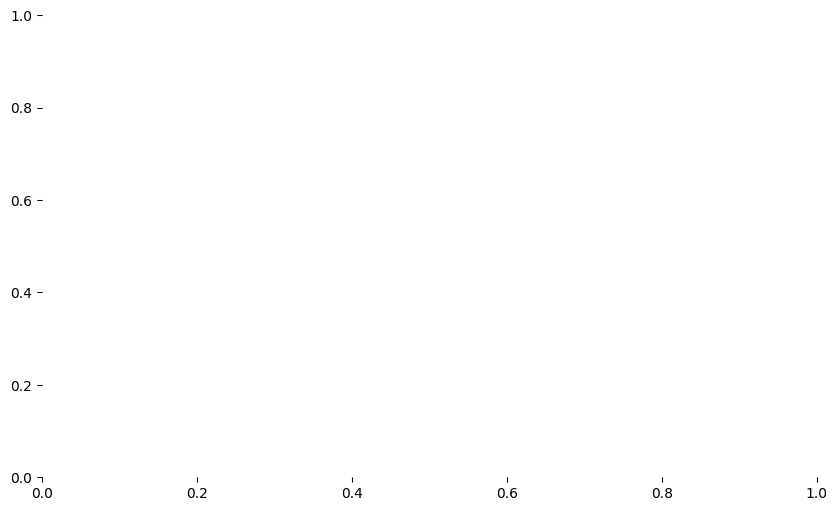

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title='Macro Average F1-Score Heatmap'):
    """
    Plots a heatmap of the macro average f1-scores for different models and sampling strategies.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the macro average f1-scores.
    title : str, optional
        The title of the heatmap. Default is 'Macro Average F1-Score Heatmap'.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'F1-Score'})
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Sampling Strategy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with the given DataFrame
formatted_df = get_macro_average_f1_score(results_total, metric='f1-score')
plot_heatmap(formatted_df)


In [39]:
for column in macro_f1_scores.columns:
    macro_f1_scores[column] = macro_f1_scores[column].astype(float)

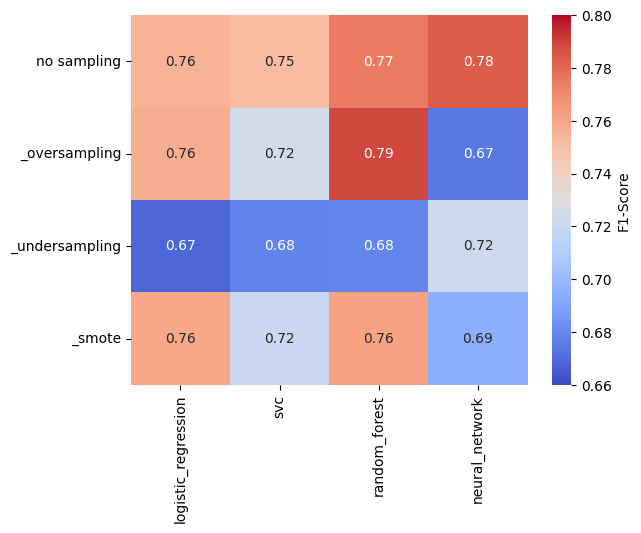

In [48]:
plt.figure()
sns.heatmap(macro_f1_scores, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'F1-Score'},
            vmin=0.66, vmax=0.80)
plt.show()